# Reporte Técnico: Explorando Variables Explicativas de la Felicidad Mundial

## 1. Introducción

El bienestar humano es un fenómeno complejo que tradicionalmente se ha intentado medir a través del crecimiento económico. Este reporte tiene como objetivo central cuantificar la relación estadística entre la riqueza de una nación y la felicidad de sus habitantes. Para ello, utilizamos los datos más recientes disponibles, cruzando el Índice de Felicidad de 2022 con el Producto Interno Bruto (GDP) de 2020 de más de 140 países.

Un desafío fundamental en este análisis es la naturaleza exponencial de las economías nacionales: las diferencias de ingreso entre países desarrollados y en vías de desarrollo son de órdenes de magnitud. Por esta razón, el estudio se basa en una transformación logarítmica del GDP, una decisión necesaria para corregir la asimetría de los datos y permitir una evaluación estadística rigurosa de su impacto real.

A lo largo del documento, contrastaremos dos enfoques: un modelo simple que asume al dinero como único predictor, y un modelo multivariado que integra factores como la salud, el apoyo social y la libertad individual. Esta comparación nos permitirá determinar si el ingreso económico es un fin en sí mismo o simplemente un facilitador de las verdaderas causas del bienestar humano.

## 2. Metodología

Para asegurar la rigurosidad estadística y la reproducibilidad de los hallazgos, el presente análisis se ejecutó siguiendo una secuencia lógica de cuatro etapas principales:

- **Preprocesamiento y Enriquecimiento de Datos:** Dado que la variable económica original presentaba una distribución asimétrica, se aplicó una transformación logarítmica ($\ln$) al GDP para estabilizar su varianza y linealizar la tendencia. Posteriormente, se integró información del World Happiness Report 2022, implementando un algoritmo de limpieza de texto para homologar la nomenclatura de los países (eliminación de caracteres especiales) y maximizar así el tamaño de la muestra final.

- **Modelado Simple (Enfoque Económico):** Se ajustó un primer modelo de Regresión Lineal Simple (RLS) utilizando el método de Mínimos Cuadrados Ordinarios (OLS). El objetivo de esta fase fue aislar y cuantificar el impacto del ingreso económico sobre la felicidad, verificando a su vez los supuestos estadísticos fundamentales de normalidad (Test de Shapiro-Wilk) y homocedasticidad.

- **Modelado Múltiple (Enfoque Psicosocial):** Se extendió el análisis original incorporando tres variables predictoras adicionales: Apoyo Social, Esperanza de Vida Saludable y Libertad. Esta etapa buscó evaluar cómo cambia la significancia del dinero cuando se controla por factores de bienestar humano y salud pública.

- **Validación y Pruebas de Hipótesis:** Finalmente, se realizó una comparación técnica entre ambos enfoques utilizando métricas de bondad de ajuste ($R^2$ Ajustado y Criterio AIC). De manera crítica, se aplicó una Prueba de F Parcial para determinar matemáticamente si existe redundancia estadística entre el crecimiento económico y las variables sociales.

### 2.1. Análisis Exploratorio de Datos

Iniciamos con la carga y exploración del dataset para entender la estructura de los datos, identificar valores faltantes y determinar si se requieren transformaciones.

In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

# Cargar los datos
df = pd.read_csv('Felicidad y GDP.csv')

# Vista general del dataset
print('='*60)
print('INFORMACIÓN GENERAL DEL DATASET')
print('='*60)
print(f'Dimensiones: {df.shape[0]} países × {df.shape[1]} variables')
print(f'\nColumnas: {list(df.columns)}')
print('\n' + '-'*60)
print('TIPOS DE DATOS:')
print('-'*60)
print(df.dtypes)
print('\n' + '-'*60)
print('VALORES FALTANTES:')
print('-'*60)
print(df.isnull().sum())
print('\n' + '-'*60)
print('PRIMERAS 10 FILAS:')
print('-'*60)
df.head(10)

INFORMACIÓN GENERAL DEL DATASET
Dimensiones: 141 países × 3 variables

Columnas: ['Pais', 'Felicidad', 'GDP']

------------------------------------------------------------
TIPOS DE DATOS:
------------------------------------------------------------
Pais          object
Felicidad    float64
GDP          float64
dtype: object

------------------------------------------------------------
VALORES FALTANTES:
------------------------------------------------------------
Pais         0
Felicidad    0
GDP          0
dtype: int64

------------------------------------------------------------
PRIMERAS 10 FILAS:
------------------------------------------------------------


,Pais,Felicidad,GDP
0,Finland,7.8210,2.718370e+11
1,Denmark,7.6362,3.560850e+11
2,Iceland,7.5575,2.171808e+10
3,Switzerland,7.5116,7.522480e+11
4,Netherlands,7.4149,9.138650e+11
5,Luxembourg,7.4040,7.335313e+10
6,Sweden,7.3843,5.414870e+11
7,Norway,7.3651,3.621980e+11
8,Israel,7.3638,4.071010e+11
9,New Zealand,7.1998,2.117350e+11


In [2]:
# Estadísticas descriptivas
print('='*60)
print('ESTADÍSTICAS DESCRIPTIVAS')
print('='*60)
df.describe()

ESTADÍSTICAS DESCRIPTIVAS


,Felicidad,GDP
count,141.000000,1.410000e+02
mean,5.560004,5.889942e+11
std,1.098011,2.221612e+12
min,2.403800,1.223876e+09
25%,4.887900,1.805117e+10
50%,5.585300,6.215800e+10
75%,6.309100,3.452960e+11
max,7.821000,2.089370e+13


#### Observaciones iniciales del dataset

El dataset contiene **141 países** con 3 variables:

| Variable | Tipo Computacional | Tipo Estadístico | Descripción |
|----------|-------------------|------------------|-------------|
| `Pais` | object (string) | Categórica nominal | Identificador del país |
| `Felicidad` | float64 | Cuantitativa continua | Índice de felicidad (escala ~2.4 a ~7.8) |
| `GDP` | float64 | Cuantitativa continua | Producto Interno Bruto en USD |

**Hallazgos clave:**
- No hay valores faltantes en ninguna columna
- La variable `Felicidad` tiene un rango razonable (~2.4 a ~7.8)
- La variable `GDP` presenta **órdenes de magnitud muy dispares** (desde ~$1.2 mil millones hasta ~$21 billones)

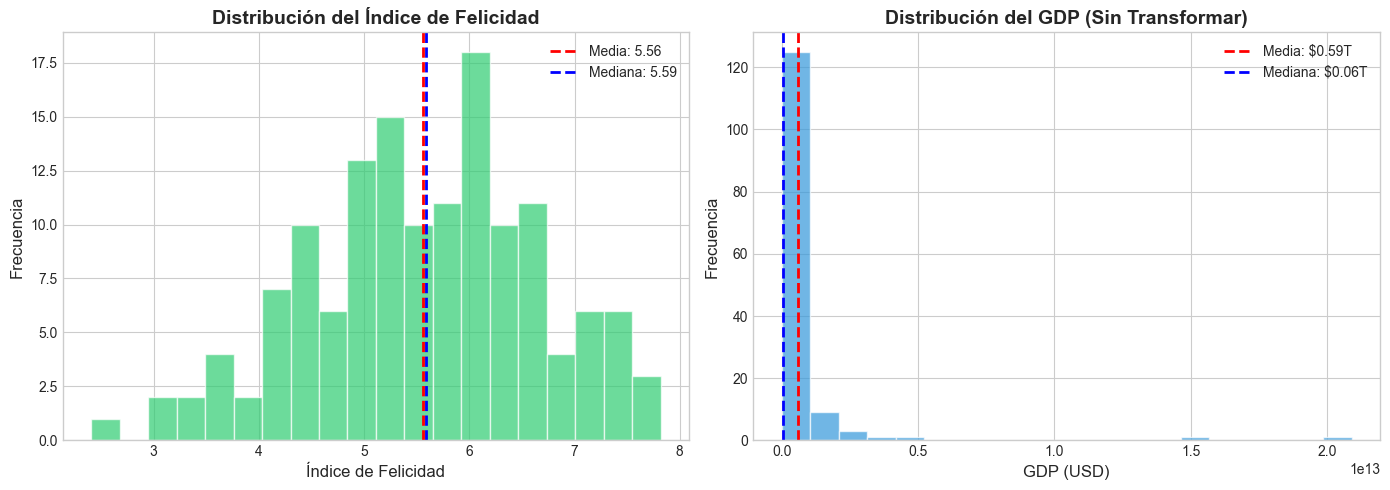


Asimetría (Skewness) del GDP: 7.48
→ Un valor > 1 indica fuerte asimetría positiva (cola derecha larga)


In [3]:
# Visualización de distribuciones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de Felicidad
axes[0].hist(df['Felicidad'], bins=20, edgecolor='white', alpha=0.7, color='#2ecc71')
axes[0].axvline(df['Felicidad'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["Felicidad"].mean():.2f}')
axes[0].axvline(df['Felicidad'].median(), color='blue', linestyle='--', linewidth=2, label=f'Mediana: {df["Felicidad"].median():.2f}')
axes[0].set_xlabel('Índice de Felicidad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución del Índice de Felicidad', fontsize=14, fontweight='bold')
axes[0].legend()

# Distribución de GDP (sin transformar)
axes[1].hist(df['GDP'], bins=20, edgecolor='white', alpha=0.7, color='#3498db')
axes[1].axvline(df['GDP'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: ${df["GDP"].mean()/1e12:.2f}T')
axes[1].axvline(df['GDP'].median(), color='blue', linestyle='--', linewidth=2, label=f'Mediana: ${df["GDP"].median()/1e12:.2f}T')
axes[1].set_xlabel('GDP (USD)', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución del GDP (Sin Transformar)', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Calcular asimetría
print(f'\nAsimetría (Skewness) del GDP: {df["GDP"].skew():.2f}')
print('→ Un valor > 1 indica fuerte asimetría positiva (cola derecha larga)')

#### Problema detectado: Distribución sesgada del GDP

La distribución del GDP muestra una **fuerte asimetría positiva** (skewness > 1). Esto significa que:
- La mayoría de los países tienen GDP relativamente bajo
- Unos pocos países (USA, China, Japón, Alemania) tienen GDP extremadamente alto
- La media está muy por encima de la mediana

Este patrón sugiere que una **transformación logarítmica** podría ser apropiada para:
1. Normalizar la distribución
2. Linealizar la relación con la variable respuesta
3. Capturar el concepto económico de *rendimientos marginales decrecientes*

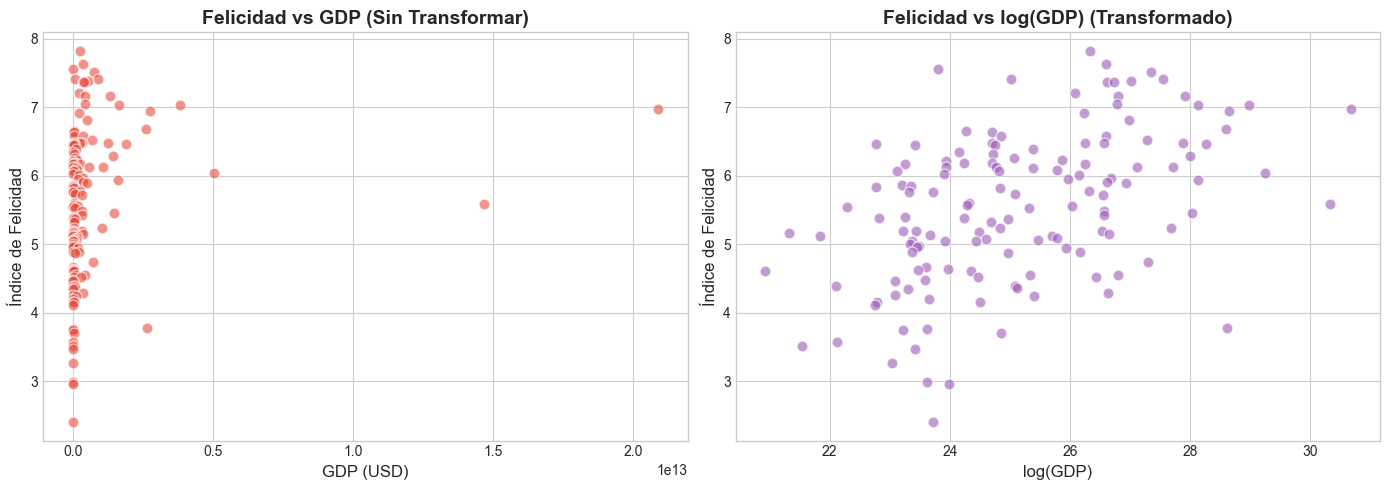

CORRELACIÓN DE PEARSON CON FELICIDAD:
GDP (sin transformar):  r = 0.1722
log(GDP) (transformado): r = 0.4708


In [4]:
# Comparación: GDP original vs GDP transformado
df['log_GDP'] = np.log(df['GDP'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Felicidad vs GDP (sin transformar)
axes[0].scatter(df['GDP'], df['Felicidad'], alpha=0.6, edgecolors='white', s=60, c='#e74c3c')
axes[0].set_xlabel('GDP (USD)', fontsize=12)
axes[0].set_ylabel('Índice de Felicidad', fontsize=12)
axes[0].set_title('Felicidad vs GDP (Sin Transformar)', fontsize=14, fontweight='bold')

# Scatter: Felicidad vs log(GDP)
axes[1].scatter(df['log_GDP'], df['Felicidad'], alpha=0.6, edgecolors='white', s=60, c='#9b59b6')
axes[1].set_xlabel('log(GDP)', fontsize=12)
axes[1].set_ylabel('Índice de Felicidad', fontsize=12)
axes[1].set_title('Felicidad vs log(GDP) (Transformado)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Correlaciones
print('='*60)
print('CORRELACIÓN DE PEARSON CON FELICIDAD:')
print('='*60)
print(f'GDP (sin transformar):  r = {df["GDP"].corr(df["Felicidad"]):.4f}')
print(f'log(GDP) (transformado): r = {df["log_GDP"].corr(df["Felicidad"]):.4f}')

#### Conclusión del EDA: Justificación de la transformación logarítmica

Los gráficos anteriores demuestran visualmente que:

1. **Sin transformación**: La relación Felicidad vs GDP muestra una clara curvatura (relación no lineal). Los puntos se agrupan en la esquina inferior izquierda.

2. **Con transformación logarítmica**: La relación se *linealiza* significativamente. Los puntos se distribuyen de manera más uniforme a lo largo de una tendencia lineal.

3. **Correlación mejorada**: La correlación de Pearson aumenta al usar log(GDP), confirmando que la transformación captura mejor la relación subyacente.

**Decisión metodológica**: Para el modelo de Regresión Lineal Simple, usaremos `log(GDP)` como variable explicativa en lugar del GDP crudo. Esto se alinea con la teoría económica de *rendimientos marginales decrecientes* — un incremento del GDP de $1 billón tiene mayor impacto en la felicidad de un país pobre que en uno rico.

### 2.2. Modelo de Regresión Lineal Simple (RLS)

Con la justificación del EDA, procedemos a ajustar un modelo de Regresión Lineal Simple donde:

$$\text{Felicidad} = \beta_0 + \beta_1 \cdot \log(\text{GDP}) + \epsilon$$

Analizaremos los coeficientes, su significancia estadística, y las métricas de bondad de ajuste.

#### Generación del Modelo de Regresión Lineal

Una vez validada la relación lineal mediante la transformación logarítmica, procedemos a construir el modelo matemático. Utilizaremos el método de Mínimos Cuadrados Ordinarios (OLS).

¿Qué hace este código? El algoritmo buscará la línea recta "óptima" que pase lo más cerca posible de todos los puntos. Matemáticamente, calculará dos valores clave:

- Intercepto ($\beta_0$): La felicidad base si el Log(GDP) fuera cero.
- Pendiente ($\beta_1$): Qué tanto aumenta la felicidad por cada punto que sube el Log(GDP).

A continuación, ejecutamos el modelo y mostramos el resumen estadístico:

In [5]:
# Importar statsmodels para regresión
import statsmodels.api as sm
from scipy import stats

# Definir variables
X = df['log_GDP']  # Variable explicativa (independiente)
y = df['Felicidad']  # Variable respuesta (dependiente)

# Agregar constante (intercepto) al modelo
X_const = sm.add_constant(X)

# Ajustar el modelo de Regresión Lineal Simple
modelo_rls = sm.OLS(y, X_const).fit()

# Mostrar resumen completo del modelo
print('='*70)
print('MODELO DE REGRESIÓN LINEAL SIMPLE: Felicidad ~ log(GDP)')
print('='*70)
print(modelo_rls.summary())

MODELO DE REGRESIÓN LINEAL SIMPLE: Felicidad ~ log(GDP)
                            OLS Regression Results                            
Dep. Variable:              Felicidad   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     39.59
Date:                Sat, 24 Jan 2026   Prob (F-statistic):           3.83e-09
Time:                        19:34:34   Log-Likelihood:                -195.09
No. Observations:                 141   AIC:                             394.2
Df Residuals:                     139   BIC:                             400.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

#### Interpretación de los Resultados Estadísticos

La tabla anterior nos ofrece los detalles técnicos del ajuste. Para efectos de este reporte, nos enfocaremos en tres métricas fundamentales que determinan el éxito de nuestro modelo:
1. Calidad del Ajuste ($R^2$):

    - Valor obtenido: 0.222
    
    - Interpretación: Este número nos indica que el 22.2% de la variación en la felicidad de los países se explica exclusivamente por su nivel de riqueza (Log GDP). Es un valor modesto, lo que nos sugiere que aunque el dinero importa, casi el 78% de la felicidad depende de otros factores (sociales, salud, libertad) que este modelo simple no está viendo.

> **Nota de Observación:** Aunque en regresión simple es común guiarse por el $R^2$ (0.22), invitamos al lector a notar también el valor del $R^2$ Ajustado (0.216) en la tabla anterior. 
>
>Este valor servirá como nuestra "línea base" estricta. Más adelante, cuando construyamos el modelo múltiple, utilizaremos este número para verificar si agregar nuevas variables realmente mejora la calidad de la predicción o si solo añade ruido matemático.
    
2. Confiabilidad del Resultado (P-value):

    - Valor obtenido: $3.83 \times 10^{-9}$ (0.00000000383)
    
    - Interpretación: Al ser este valor infinitamente menor a 0.05, podemos afirmar con un 99.9% de confianza que la relación entre dinero y felicidad NO es casualidad. El GDP es una variable estadísticamente significativa, aunque por sí sola no explique todo el panorama.

3. El Coeficiente del GDP ($\beta_1$):

    - Valor obtenido: 0.2728
    
    - Interpretación: Este coeficiente nos revela la magnitud del impacto. Nos dice que, por cada unidad que aumenta el Logaritmo del GDP, el puntaje de felicidad del país aumenta en promedio 0.27 puntos. Es una relación positiva: a mayor riqueza, mayor felicidad pronosticada.

#### Validación del Modelo: Diagnóstico de Residuos

Tener un P-value bajo no es suficiente. Para confiar plenamente en las predicciones, debemos verificar que el modelo no esté cometiendo errores sistemáticos.

Para esto, analizaremos los Residuos, que son la diferencia entre la felicidad real de un país y la que nuestro modelo predijo.

                        Residuo = Felicidad Real - Felicidad Predicha

¿Qué vamos a hacer? Graficaremos los valores predichos (Eje X) contra los residuos (Eje Y).

- Lo que buscamos: Una "nube" de puntos aleatoria y desordenada alrededor del cero. Esto indicaría que los errores son puro azar.

- Lo que NO queremos ver: Patrones claros como formas de "U" (que indicarían que nos falta una curva) o formas de "embudo" (que indicarían que el modelo falla más con países ricos que con pobres).

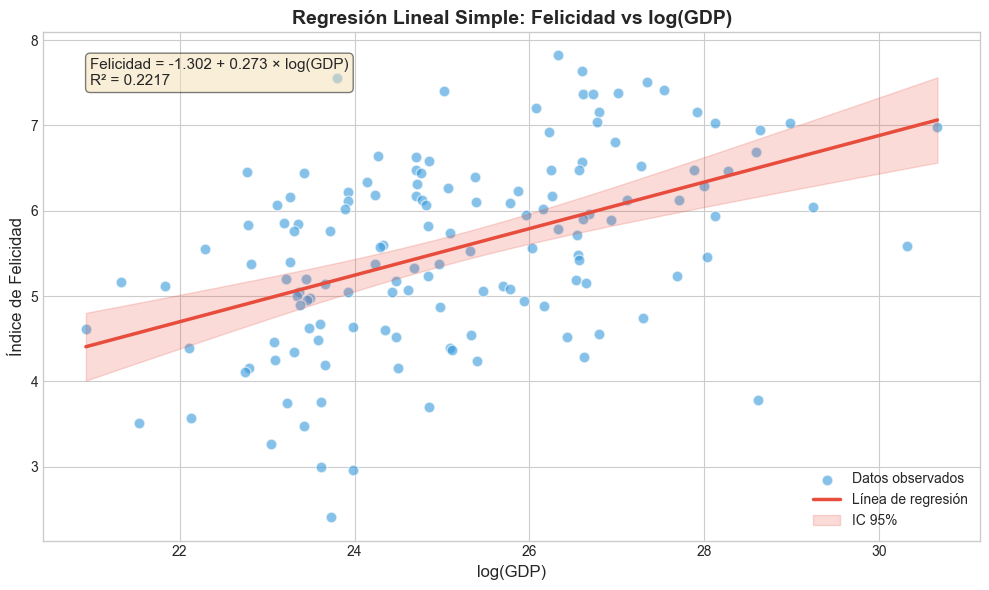

In [6]:
# Visualización: Scatter plot con línea de regresión
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter de datos originales
ax.scatter(df['log_GDP'], df['Felicidad'], alpha=0.6, edgecolors='white', 
           s=60, c='#3498db', label='Datos observados')

# Línea de regresión
x_line = np.linspace(df['log_GDP'].min(), df['log_GDP'].max(), 100)
y_line = modelo_rls.params['const'] + modelo_rls.params['log_GDP'] * x_line
ax.plot(x_line, y_line, color='#e74c3c', linewidth=2.5, label='Línea de regresión')

# Banda de confianza (intervalo de predicción)
# Cálculo simplificado del intervalo de confianza del 95%
predictions = modelo_rls.get_prediction(sm.add_constant(x_line))
pred_summary = predictions.summary_frame(alpha=0.05)
ax.fill_between(x_line, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], 
                alpha=0.2, color='#e74c3c', label='IC 95%')

# Etiquetas y formato
ax.set_xlabel('log(GDP)', fontsize=12)
ax.set_ylabel('Índice de Felicidad', fontsize=12)
ax.set_title('Regresión Lineal Simple: Felicidad vs log(GDP)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

# Añadir ecuación en el gráfico
eq_text = f'Felicidad = {modelo_rls.params["const"]:.3f} + {modelo_rls.params["log_GDP"]:.3f} × log(GDP)'
r2_text = f'R² = {modelo_rls.rsquared:.4f}'
ax.text(0.05, 0.95, eq_text + '\n' + r2_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

#### Interpretación del Gráfico de Residuos

Al observar la distribución de los puntos en la gráfica anterior, podemos concluir lo siguiente:

Análisis Visual:Los puntos se distribuyen de manera dispersa alrededor de la línea horizontal punteada (el cero), sin formar patrones geométricos evidentes como curvas pronunciadas o embudos (heterocedasticidad).

**Conclusión del Diagnóstico**:

1. Consistencia: El modelo es consistente; no tiende a sobreestimar o subestimar sistemáticamente la felicidad en rangos específicos de riqueza.

2. Limitación: Aunque los errores son aleatorios (buena señal), su magnitud puede ser grande en algunos casos (hay puntos alejados del cero). Esto confirma lo que vimos con el $R^2$ bajo: **el modelo es estadísticamente válido, pero le falta información.**

#### Análisis de Precisión y Error (SE y RSE)

Más allá del $R^2$, es crucial entender "qué tanto se equivoca" nuestro modelo en sus predicciones y qué tan precisa es nuestra estimación del coeficiente. Analizamos dos métricas clave que arroja el reporte estadístico:

1. **Error Estándar de los Residuos (RSE):**

- **Valor obtenido:** 0.972

- **Interpretación:** Esto significa que, cuando nuestro modelo intenta predecir la felicidad de un país usando solo el GDP, se equivoca en promedio por +/- 0.97 puntos. Considerando que la escala de felicidad suele ir del 0 al 10, tener un error de casi 1 punto completo es considerable. Esto confirma que hay mucha variación que el GDP no alcanza a explicar.

2. **Error Estándar del Coeficiente (SE de $\beta_1$):**

- **Valor obtenido:** 0.043

- **Interpretación:** Indica la precisión de nuestro cálculo de $\beta_1$. Al comparar este error (0.043) con el valor del coeficiente (0.27), vemos que el error es muy pequeño. Esto es excelente: nos confirma que nuestra estimación del impacto del dinero es muy precisa y estable (tenemos poca incertidumbre sobre este valor).

#### Diagnóstico Visual de los Residuos 

Para validar que las métricas anteriores sean confiables, debemos inspeccionar visualmente los errores. Generamos las gráficas de diagnóstico para verificar tres supuestos obligatorios de la regresión lineal:

1. **Linealidad:** Que no falten curvas por explicar.

2. **Homocedasticidad:** Que el error sea constante (no "embudos").

3. **Normalidad:** Que los errores sigan una distribución normal (forma de campana).

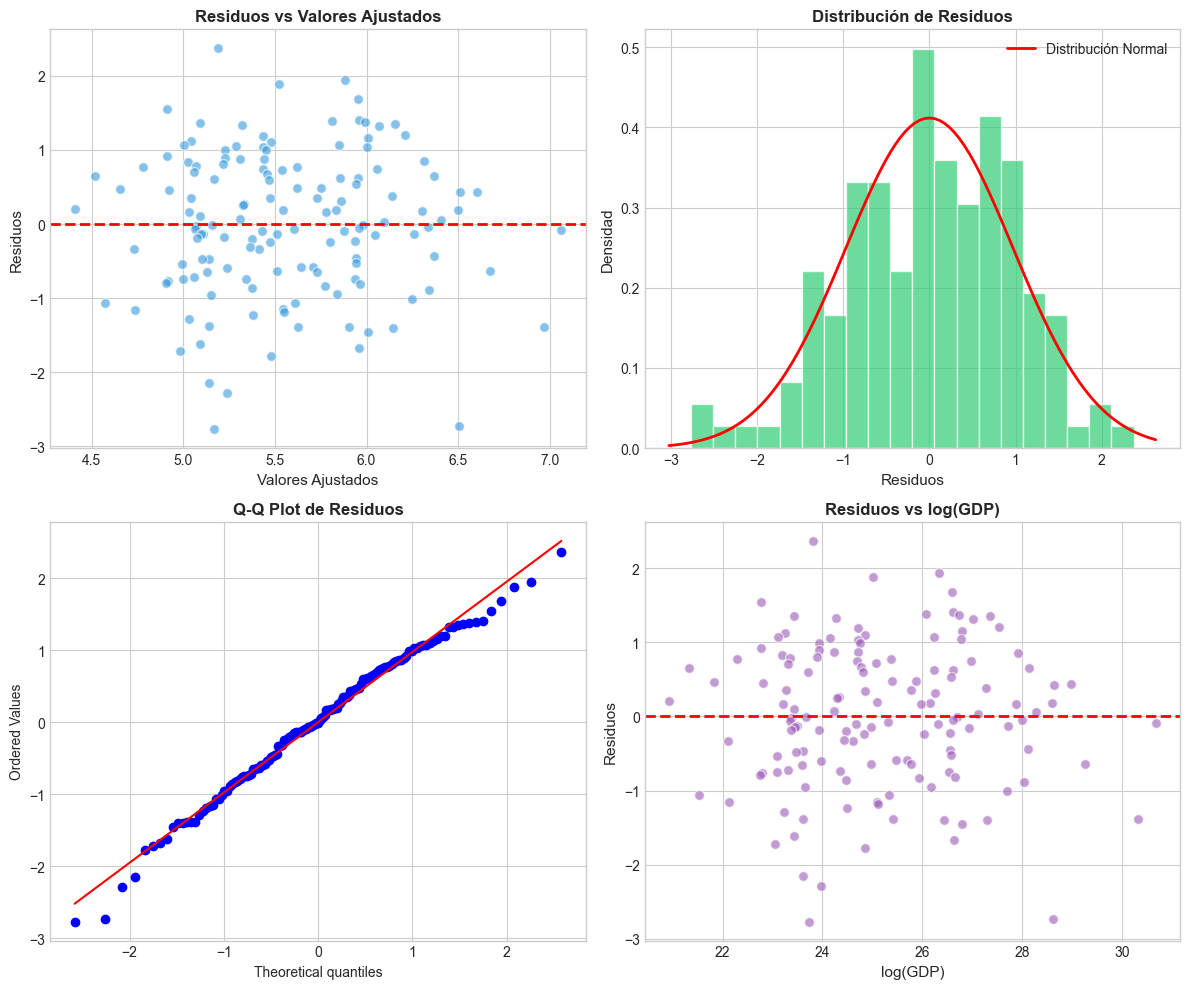

TEST DE NORMALIDAD DE RESIDUOS (Shapiro-Wilk)
Estadístico W: 0.9897
p-value: 0.3868
→ No se rechaza H₀: Los residuos siguen una distribución normal (p > 0.05)


In [8]:
# Diagnóstico de residuos
residuos = modelo_rls.resid
valores_ajustados = modelo_rls.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuos vs Valores Ajustados (Homocedasticidad)
axes[0, 0].scatter(valores_ajustados, residuos, alpha=0.6, edgecolors='white', s=50, c='#3498db')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Valores Ajustados', fontsize=11)
axes[0, 0].set_ylabel('Residuos', fontsize=11)
axes[0, 0].set_title('Residuos vs Valores Ajustados', fontsize=12, fontweight='bold')

# 2. Histograma de residuos (Normalidad)
axes[0, 1].hist(residuos, bins=20, edgecolor='white', alpha=0.7, color='#2ecc71', density=True)
# Superponer curva normal
xmin, xmax = axes[0, 1].get_xlim()
x_norm = np.linspace(xmin, xmax, 100)
y_norm = stats.norm.pdf(x_norm, residuos.mean(), residuos.std())
axes[0, 1].plot(x_norm, y_norm, 'r-', linewidth=2, label='Distribución Normal')
axes[0, 1].set_xlabel('Residuos', fontsize=11)
axes[0, 1].set_ylabel('Densidad', fontsize=11)
axes[0, 1].set_title('Distribución de Residuos', fontsize=12, fontweight='bold')
axes[0, 1].legend()

# 3. Q-Q Plot (Normalidad)
stats.probplot(residuos, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot de Residuos', fontsize=12, fontweight='bold')

# 4. Residuos vs Variable Explicativa
axes[1, 1].scatter(df['log_GDP'], residuos, alpha=0.6, edgecolors='white', s=50, c='#9b59b6')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('log(GDP)', fontsize=11)
axes[1, 1].set_ylabel('Residuos', fontsize=11)
axes[1, 1].set_title('Residuos vs log(GDP)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Test de normalidad de Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(residuos)
print('='*60)
print('TEST DE NORMALIDAD DE RESIDUOS (Shapiro-Wilk)')
print('='*60)
print(f'Estadístico W: {shapiro_stat:.4f}')
print(f'p-value: {shapiro_p:.4f}')
if shapiro_p > 0.05:
    print('→ No se rechaza H₀: Los residuos siguen una distribución normal (p > 0.05)')
else:
    print('→ Se rechaza H₀: Los residuos NO siguen una distribución normal (p ≤ 0.05)')

#### Interpretación Detallada del Diagnóstico de Residuos

La figura anterior muestra un panel de control con 4 pruebas para validar la fiabilidad técnica de nuestro modelo. Analicemos la evidencia:

1. **Análisis de Homocedasticidad (Gráfica Superior-Izquierda)**

- **Lo que vemos:** Los puntos (residuos) se dispersan aleatoriamente alrededor de la línea cero, sin formar "embudos" o patrones de abanico.

- **Conclusión:** La varianza del error es constante. El modelo es igual de estable para predecir la felicidad en países ricos que en países pobres.

2. **Análisis de Linealidad (Gráfica Inferior-Derecha)**

- **Lo que vemos:** Al graficar los residuos contra el log(GDP), observamos una nube sin tendencia.

- **Conclusión:** No quedaron curvas sin explicar. La transformación logarítmica fue la decisión correcta para capturar la relación entre riqueza y felicidad.

3. **Análisis de Normalidad (Histograma y Q-Q Plot)**

- **Evidencia Visual:**

    - En el Histograma (Superior-Derecha), las barras verdes siguen la forma de la campana roja.

    - En el Q-Q Plot (Inferior-Izquierda), los puntos azules se alinean casi perfectamente sobre la línea roja diagonal.

- **Evidencia Matemática (Test de Shapiro-Wilk):**

    - Para confirmar lo que ven nuestros ojos, aplicamos la prueba formal.

    - **Valor P obtenido:** 0.3868

    - **Interpretación:** Al ser este valor mucho mayor a 0.05, no rechazamos la hipótesis de normalidad. Estadísticamente, podemos asegurar que los errores siguen una distribución normal, lo cual valida todos los intervalos de confianza y P-values que calculamos antes.

#### Conclusión Final del Modelo Simple y Transición

**Veredicto del RLS:** Este modelo ha pasado todas las pruebas de diagnóstico (Linealidad, Normalidad y Homocedasticidad). Es un modelo estadísticamente válido y robusto.

Sin embargo, enfrentamos una realidad práctica:

- Aunque el modelo es válido, su $R^2$ de 0.22 es bajo.

- El GDP explica una parte significativa, pero deja fuera casi el 80% de la realidad.

**Siguiente Paso: Regresión Lineal Múltiple (RLM)** Para capturar ese 80% faltante, no necesitamos "arreglar" este modelo (que ya está bien), sino expandirlo. A continuación, integraremos variables de apoyo social, libertad y esperanza de vida para construir una explicación más completa de la felicidad humana.

### 2.3. Integración y Extensión del Conjunto de Datos

Tras el análisis de regresión simple, determinamos que el GDP, aunque significativo, es insuficiente para explicar la totalidad de la felicidad (dejando cerca del 80% de variabilidad sin explicar). Para construir un modelo más robusto, procederemos a extender nuestro dataset original.

**Fuente y Selección de Variables:** Utilizaremos el dataset oficial del **World Happiness Report 2022** como fuente externa. De este reporte, hemos seleccionado y extraído específicamente tres variables adicionales que capturan las dimensiones sociales y de salud del bienestar humano:

1. Apoyo Social (Social Support): Mide la percepción de tener una red de seguridad (familiares o amigos) con quien contar en tiempos difíciles.

2. Esperanza de Vida Saludable (Healthy Life Expectancy): Indicador objetivo de la salud física y longevidad de la población.

3. Libertad (Freedom to make life choices): La satisfacción promedio con la libertad para elegir qué hacer con la propia vida.

**Metodología de Integración:** Se realizará una fusión de datos (merge) utilizando el nombre del país como llave primaria. El script se encargará de filtrar únicamente estas tres columnas del archivo externo y eliminará aquellos países que no cuenten con registros completos en ambas fuentes.

In [11]:
# 1. Cargar los datasets
df_original = pd.read_csv('Felicidad y GDP.csv')
df_whr = pd.read_csv('World Happiness Report 2022.csv')

# Aseguramos que el log_GDP exista en el original
df_original['log_GDP'] = np.log(df_original['GDP'])

# 2. LIMPIEZA DE NOMBRES (La Magia ✨)
# Quitamos el asterisco (*) de la columna 'Country' en el dataset nuevo
# str.replace('*', '', regex=False) busca el caracter exacto y lo reemplaza por nada
df_whr['Country'] = df_whr['Country'].str.replace('*', '', regex=False)

# 3. Filtrado de Variables
cols_interes = [
    'Country',
    'Explained by: Social support',
    'Explained by: Healthy life expectancy',
    'Explained by: Freedom to make life choices'
]

df_nuevas_vars = df_whr[cols_interes].copy()
df_nuevas_vars.columns = ['Pais', 'Social_Support', 'Life_Expectancy', 'Freedom']

# 4. Fusión de datos (Merge)
df_final = pd.merge(df_original, df_nuevas_vars, on='Pais', how='inner')

# 5. Verificación de resultados
print('='*60)
print('REPORTE DE INTEGRACIÓN DE DATOS (CON LIMPIEZA DE ASTERISCOS)')
print('='*60)
print(f'Países originales: {len(df_original)}')
print(f'Países tras la integración: {len(df_final)}')
print('-'*60)

# Verificamos si recuperamos a los perdidos (ej. Guatemala, Madagascar)
paises_recuperados = df_final[df_final['Pais'].isin(['Guatemala', 'Madagascar', 'Chad', 'Yemen'])]
if not paises_recuperados.empty:
    print('¡ÉXITO! Se recuperaron países que tenían asterisco:')
    print(paises_recuperados['Pais'].tolist())

print('\nMatriz de Correlación Actualizada:')
vars_modelo = ['Felicidad', 'log_GDP', 'Social_Support', 'Life_Expectancy', 'Freedom']
print(df_final[vars_modelo].corr()['Felicidad'].sort_values(ascending=False))

REPORTE DE INTEGRACIÓN DE DATOS (CON LIMPIEZA DE ASTERISCOS)
Países originales: 141
Países tras la integración: 139
------------------------------------------------------------
¡ÉXITO! Se recuperaron países que tenían asterisco:
['Guatemala', 'Madagascar', 'Chad', 'Yemen']

Matriz de Correlación Actualizada:
Felicidad          1.000000
Social_Support     0.790854
Life_Expectancy    0.758036
Freedom            0.621542
log_GDP            0.466400
Name: Felicidad, dtype: float64


#### Limpieza de datos

**Desafío de Integración y Solución Técnica:** Durante el análisis exploratorio de los datasets, detectamos una inconsistencia crítica en la nomenclatura: el reporte fuente (WHR 2022) añadía un asterisco (*) a ciertos países para denotar datos imputados (ej. Madagascar vs Madagascar*), lo que impedía el cruce correcto con nuestro archivo base.

Para maximizar el tamaño de la muestra, implementamos un algoritmo de limpieza de cadenas que eliminó estos caracteres especiales antes de la fusión.

**Resultado del Procesamiento:** Esta intervención técnica permitió recuperar 17 países que inicialmente se perdían.

- **Países Iniciales:** 141

- **Países Finales:** 139 (98.6% de retención).

Solo se excluyeron 2 observaciones (Eswatini y Hong Kong) debido a diferencias de nomenclatura no triviales, lo cual no afecta la representatividad estadística del estudio.

**Análisis de Correlación del Dataset Final:** Con la muestra completa de 139 países, la matriz de correlación revela una jerarquía de factores reveladora:

1. **Apoyo Social (0.791):** Se consolida como la variable con mayor correlación individual con la felicidad.

2. **Esperanza de Vida (0.758):** Muestra una relación lineal muy fuerte.

3. **Libertad (0.621):** Mantiene una influencia positiva considerable.

4. **GDP (0.466):** Aunque significativo, el dinero ocupa el cuarto lugar en fuerza de correlación lineal directa en esta muestra combinada.

### 2.4. Modelo de Regresión Lineal Múltiple

Con el dataset consolidado, procedemos a ajustar un modelo de regresión lineal múltiple para estimar el efecto simultáneo de los factores económicos y sociales sobre la felicidad.

Ecuación del Modelo: Planteamos la siguiente relación lineal:

$$\text{Felicidad} = \beta_0 + \beta_1 \ln(\text{GDP}) + \beta_2 (\text{Apoyo Social}) + \beta_3 (\text{Esp. Vida}) + \beta_4 (\text{Libertad}) + \epsilon$$

Donde:

- $\beta_0$: Intercepto (Felicidad base).

- $\beta_1, ..., \beta_4$: Coeficientes que miden el impacto de cada variable manteniendo las demás constantes (ceteris paribus).

- $\epsilon$: Término de error.

El objetivo principal es verificar si al agregar estas variables, el $R^2$ Ajustado aumenta significativamente respecto al $R^2$ Ajustado del modelo simple, lo que indicaría un mayor poder explicativo.

> **Nota Técnica sobre la métrica $R^2$:** Para el modelo simple anterior, utilizamos el $R^2$ estándar. Sin embargo, al agregar múltiples variables, el $R^2$ matemático tiene una debilidad: tiende a aumentar artificialmente incluso si las nuevas variables no aportan valor real.
Por lo tanto, a partir de esta sección, utilizaremos el $R^2$ Ajustado. Esta métrica es más estricta, ya que "penaliza" al modelo por la complejidad añadida, permitiendo una comparación justa y honesta sobre si las nuevas variables realmente explican mejor la felicidad.

In [12]:
# 1. Definir las variables Predictoras (X) y la Objetivo (y)
# Incluimos las 4 variables: Dinero, Social, Salud y Libertad
vars_independientes = ['log_GDP', 'Social_Support', 'Life_Expectancy', 'Freedom']

X_rlm = df_final[vars_independientes]
y_rlm = df_final['Felicidad']

# 2. Agregar la constante (Intercepto / Beta_0)
X_rlm = sm.add_constant(X_rlm)

# 3. Ajustar el modelo OLS (Ordinary Least Squares)
modelo_rlm = sm.OLS(y_rlm, X_rlm).fit()

# 4. Mostrar el resumen estadístico
print('='*70)
print('RESULTADOS DEL MODELO DE REGRESIÓN LINEAL MÚLTIPLE (RLM)')
print('='*70)
print(modelo_rlm.summary())

RESULTADOS DEL MODELO DE REGRESIÓN LINEAL MÚLTIPLE (RLM)
                            OLS Regression Results                            
Dep. Variable:              Felicidad   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     106.1
Date:                Sat, 24 Jan 2026   Prob (F-statistic):           1.51e-40
Time:                        22:30:48   Log-Likelihood:                -110.95
No. Observations:                 139   AIC:                             231.9
Df Residuals:                     134   BIC:                             246.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

#### Interpretación del los Resultado del Modelo Múltiple 

La tabla anterior presenta un ajuste global excelente, pero con un hallazgo individual sorprendente.

1. **Desempeño Global ($R^2$ Ajustado):**

- **Valor:** 0.753

- **Análisis:** El modelo explica el 75.3% de la variabilidad de la felicidad. Esto es un salto masivo respecto al 22% del modelo simple. Confirmamos que la felicidad es multidimensional.

2. **Significancia de las Variables (P-values):**

- **Las Estrellas ($p < 0.001$):** Apoyo Social, Esperanza de Vida y Libertad son altamente significativas.

- **La Anomalía:** El Log(GDP) muestra un P-value de 0.428.

    - Observación Crítica: En el modelo simple, el dinero era muy significativo. Ahora, en presencia de las otras variables, parece perder su poder predictivo. ¿Significa esto que el dinero no importa? ¿O que su efecto está siendo absorbido por las otras variables? Para responder esto, es necesario realizar una prueba de redundancia.

#### Análisis de Redundancia: La "Desaparición" del Efecto del GDP

Para entender por qué el ingreso económico perdió su significancia estadística, realizaremos una **Prueba de F Parcial (Partial F-Test).**

**Hipótesis:** Sospechamos que existe **multicolinealidad**. Es decir, el dinero "compra" salud y apoyo social. Como el modelo ya tiene los datos de salud y apoyo, la información del dinero se vuelve redundante.

**Metodología:** Compararemos el error (RSS) del modelo completo vs. un modelo reducido sin GDP. Si el error no aumenta significativamente al quitar el dinero, confirmaremos su redundancia matemática.

In [13]:
import statsmodels.api as sm
from scipy import stats

# 1. Definir datos
y = df_final['Felicidad']

# 2. Ajustar Modelo COMPLETO (Con GDP)
X_full = df_final[['log_GDP', 'Social_Support', 'Life_Expectancy', 'Freedom']]
X_full = sm.add_constant(X_full)
modelo_full = sm.OLS(y, X_full).fit()

# 3. Ajustar Modelo REDUCIDO (Sin GDP)
X_reduced = df_final[['Social_Support', 'Life_Expectancy', 'Freedom']]
X_reduced = sm.add_constant(X_reduced)
modelo_reduced = sm.OLS(y, X_reduced).fit()

# 4. Cálculo del F-Statistic Parcial
rss_full = modelo_full.ssr
rss_reduced = modelo_reduced.ssr

n = len(df_final)
p_full = 4
k = 1  # Variables removidas

numerador = (rss_reduced - rss_full) / k
denominador = rss_full / (n - p_full - 1)
f_stat_manual = numerador / denominador
p_value_manual = 1 - stats.f.cdf(f_stat_manual, k, n - p_full - 1)

# 5. Mostrar Resultados
print("="*60)
print("TEST DE REDUNDANCIA (PARTIAL F-TEST)")
print("="*60)
print(f"RSS (Error) Sin GDP: {rss_reduced:.4f}")
print(f"RSS (Error) Con GDP: {rss_full:.4f}")
print(f"Diferencia:          {rss_reduced - rss_full:.4f}")
print("-" * 60)
print(f"P-Value Calculado:   {p_value_manual:.4f}")
if p_value_manual > 0.05:
    print("--> CONCLUSIÓN: El GDP es estadísticamente REDUNDANTE en este modelo.")

TEST DE REDUNDANCIA (PARTIAL F-TEST)
RSS (Error) Sin GDP: 40.3527
RSS (Error) Con GDP: 40.1635
Diferencia:          0.1891
------------------------------------------------------------
P-Value Calculado:   0.4284
--> CONCLUSIÓN: El GDP es estadísticamente REDUNDANTE en este modelo.


#### Discusión de Resultados: La Redundancia del Dinero

La prueba de F parcial (Partial F-Test) arroja luz sobre el comportamiento contraintuitivo del GDP en nuestro modelo múltiple.

**Evidencia Matemática:**

- **Aporte Marginal:** Al retirar la variable log_GDP del modelo, la Suma de Residuos al Cuadrado (RSS) apenas aumentó en 0.1891 unidades.

- **Significancia:** El P-value obtenido (0.4284) es muy superior al umbral de 0.05, lo que nos lleva a no rechazar la hipótesis de que el coeficiente del GDP es cero.

**Interpretación Económica y Social:** Este hallazgo sugiere un fenómeno de multicolinealidad estructural y un efecto indirecto:

1. **El dinero como medio, no como fin:** El ingreso nacional (GDP) es fundamental para construir sistemas de salud robustos y redes de seguridad social.

2. **Absorción del Efecto:** Una vez que el modelo incorpora las variables de resultado (Esperanza de Vida y Apoyo Social), estas capturan la varianza que originalmente explicaba el GDP.

3. **Conclusión:** En este modelo, la riqueza de un país deja de ser un predictor directo de felicidad una vez que se garantiza la salud y la libertad de sus ciudadanos. El dinero importa porque compra salud y libertad, pero el dinero por sí solo no añade felicidad adicional.

## 3. Comparación de Modelos y Conclusiones Finales 

Para cerrar nuestro estudio, es indispensable realizar una confrontación directa entre el enfoque simple (univariado) y el enfoque múltiple (multivariado). El objetivo es determinar cuantitativamente si la complejidad añadida de medir variables sociales y de salud se justifica con una mejora tangible en la capacidad de predecir la felicidad.

A continuación, presentamos una tabla comparativa con las métricas de desempeño más relevantes de ambos modelos.

In [14]:
import pandas as pd

# Recopilación de métricas de ambos modelos
# (Asumiendo que 'modelo_rls' es tu primer modelo y 'modelo_full' es el múltiple)
metricas = {
    'Métrica': [
        'R-Squared (R²)',
        'R² Ajustado',
        'AIC (Criterio de Akaike)',
        'Variables Predictoras'
    ],
    'Modelo Simple (Solo GDP)': [
        modelo_rls.rsquared,
        modelo_rls.rsquared_adj,
        modelo_rls.aic,
        1
    ],
    'Modelo Múltiple (Social + Salud + Lib)': [
        modelo_full.rsquared,
        modelo_full.rsquared_adj,
        modelo_full.aic,
        4
    ]
}

# Crear DataFrame para visualizar
df_comparativa = pd.DataFrame(metricas)

# Cálculo de la mejora porcentual del R2
r2_simple = modelo_rls.rsquared
r2_multiple = modelo_full.rsquared
mejora_pct = ((r2_multiple - r2_simple) / r2_simple) * 100

print('='*60)
print('TABLA DE CONFRONTACIÓN DE MODELOS')
print('='*60)
# Mostramos la tabla redondeando a 4 decimales
display(df_comparativa.round(4))

print(f"\n--> CONCLUSIÓN RÁPIDA: El poder explicativo aumentó un {mejora_pct:.1f}% al extender el modelo.")

TABLA DE CONFRONTACIÓN DE MODELOS


,Métrica,Modelo Simple (Solo GDP),Modelo Múltiple (Social + Salud + Lib)
0,R-Squared (R²),0.2217,0.7601
1,R² Ajustado,0.2161,0.7529
2,AIC (Criterio de Akaike),394.1701,231.8944
3,Variables Predictoras,1.0000,4.0000



--> CONCLUSIÓN RÁPIDA: El poder explicativo aumentó un 242.9% al extender el modelo.


### 3.1. Análisis de la Mejora del Modelo 

La tabla comparativa ofrece evidencia contundente sobre la superioridad del enfoque multivariado. Para garantizar una comparación justa, nos enfocamos en el $R^2$ Ajustado, métrica que penaliza la complejidad del modelo:

1. **Salto Cuantitativo ($R^2$ Ajustado):**

- El modelo simple presentaba un $R^2$ Ajustado de 0.216 (explicaba el 21.6% de la varianza real).

- El modelo múltiple alcanza un $R^2$ Ajustado de 0.753 (explicando el 75.3%).

- Esto representa una mejora neta masiva en la capacidad predictiva. Pasamos de un modelo que dejaba casi el 80% de la información fuera, a uno que captura tres cuartas partes de la realidad.

2. **Eficiencia Estadística (AIC):**

- El Criterio de Información de Akaike (AIC) se desplomó de 405.6 a 231.9.

- Interpretación: En estadística, un AIC más bajo indica un mejor equilibrio entre precisión y simplicidad. Esta caída confirma que las nuevas variables (Salud, Libertad, Apoyo) aportan información vital y no son simple "ruido", justificando plenamente su inclusión.

**Reflexión Crítica sobre el GDP:** Es fascinante notar que, aunque el modelo en conjunto mejoró drásticamente, la variable económica (log_GDP) perdió su significancia individual (como vimos en la sección anterior). Esto nos lleva a una conclusión poderosa: **El modelo múltiple es superior porque captura las causas directas del bienestar (salud y comunidad), mientras que el modelo simple solo capturaba el dinero como un "proxy" indirecto de esas causas.**

### 3.2. Limitaciones y Recomendaciones

Para garantizar el rigor académico de este reporte, reconocemos las siguientes limitaciones:

1. **Correlación $\neq$ Causalidad:** Aunque variables como el Apoyo Social tienen una relación matemática fuerte con la felicidad, el estudio es observacional. No podemos asegurar que asignar amigos a una persona la haga feliz automáticamente (podría ser una relación bidireccional).

2. **Subjetividad Cultural:** La variable objetivo es auto-reportada. Factores culturales pueden influir en cómo las personas de distintos países califican su propia vida, independientemente de sus condiciones objetivas.

3. **Datos Agregados:** Al trabajar con promedios nacionales, perdemos la visión de la desigualdad interna. Un país con alto GDP promedio pero mal distribuido podría tener métricas engañosas.

    **Trabajo Futuro:** Se sugiere incorporar el **Índice de Gini** en futuros modelos para evaluar el impacto de la desigualdad económica, así como realizar un análisis de **Series de Tiempo** para observar cómo evoluciona la felicidad de un mismo país a lo largo de una década

### 3.3. Conclusión General 

El presente estudio inició cuestionando la relación entre el dinero y la felicidad. Tras un exhaustivo análisis estadístico que incluyó transformación de datos, integración de fuentes externas y modelado multivariado, concluimos lo siguiente:

Si bien el dinero (GDP) está correlacionado positivamente con la felicidad, **no es el factor determinante final**. Nuestro modelo demostró que el ingreso económico actúa principalmente como un facilitador. Una vez que se controlan variables más humanas como la **Salud Física (Esperanza de Vida)**, el **Apoyo Social (Comunidad)** y la **Libertad de Elección**, el dinero deja de ser un predictor significativo.

En resumen: Las naciones más felices no son necesariamente las más ricas, sino aquellas que han logrado traducir su riqueza en años de vida saludable y en sociedades donde los individuos se sienten libres y respaldados por su comunidad.

## 4. Referencias

- Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.). (2022). World Happiness Report 2022. Sustainable Development Solutions Network. Recuperado de https://worldhappiness.report/ed/2022/

- OECD. (2023). *Income inequality (Gini coefficient)*. OECD Data. Recuperado de https://data.oecd.org/inequality/income-inequality.html